In [6]:
%load_ext autoreload
%autoreload 2

import sys

In [9]:
import os
import array
import re

import pandas
import numpy

import plotly.express
import librosa
from matplotlib import pyplot as plt

from software.dataset.hussain2021 import load_data, load_meta
from firmware.process import GravitySplitter

In [ ]:

#dataset_path = './data/hx5kkkbr3j-1'
combined_path = './data2/hussain2021_accelerometer_brush_manual.parquet'
samplerate = 50
lower = 2.0
upper = 5.0

In [ ]:
acc_re = pandas.read_parquet(combined_path)
data_columns = ['acc_x', 'acc_y', 'acc_z', 'elapsed']
index_columns = ['filename', 'time']
meta_columns = list(set(acc_re.columns) - set(data_columns) - set(index_columns))
acc_re

In [ ]:
filename_meta =  acc_re.reset_index().groupby('filename').first()[meta_columns]
filename_meta.head(3)

In [ ]:
acc_re.reset_index().filename.nunique()

In [ ]:

def design_bandpass(lower=2.0, upper=5.0, sr=100, order=2):
    from scipy.signal import iirfilter
    
    sos = iirfilter(order, [lower, upper], btype='band',
                    analog=False, fs=sr, output='sos',
                    ftype='cheby1', rp=2.0)

    return sos

def plot_bandpass(sos, lower, upper, fmin=0.1, sr=50):

    from scipy.signal import sosfreqz
    import numpy as np
    
    w, h = sosfreqz(sos, 10000, fs=sr)
    fig, ax = plt.subplots(1)
    ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
    
    ax.set_title('Bandpass frequency response')
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Amplitude [dB]')
    ax.axis((fmin, sr/2.0, -100, 10))
    ax.grid(which='both', axis='both')
    for f in [lower, upper]:
        ax.axvline(f, ls='--', alpha=0.5, color='black')
    return fig


sos = design_bandpass(lower=lower, upper=upper, sr=samplerate, order=2)
plot_bandpass(sos, lower=lower, upper=upper, sr=samplerate);

In [ ]:

# TODO: use micropython to process
def process(df, sr, bandpass_filter=None, groupby='filename', columns=['acc_x', 'acc_y', 'acc_z'], time='time'):

    def process_timeseries(g, splitter=None):
        g = g.sort_values(time)
        
        splitter = GravitySplitter(samplerate=sr)

        out = []
        index_values = []
        for idx, row in g.iterrows():
            xyz = array.array('f', row[columns])
            splitter.process(xyz)
        
            values = list(splitter.gravity) + list(splitter.motion)
            out.append(values)
            index_values.append(idx)

        names = ['gravity_x', 'gravity_y', 'gravity_z', 'motion_x', 'motion_y', 'motion_z']
        o = pandas.DataFrame(out, columns=names)
        o.index = g.index

        # apply bandpass
        bandpass_columns = ['motion_x', 'motion_y', 'motion_z']
        if bandpass_filter is not None:
            from scipy.signal import sosfilt
            for c in bandpass_columns:
                o[f'bandpass_{c}'] = sosfilt(bandpass_filter, o[c])
        
        print('pp', len(o))
        return o

    groups = df.groupby(groupby, as_index=False)
    print('groups', len(groups))
    f = groups.apply(process_timeseries, include_groups=False)
    f.index = f.index.droplevel(0)
    #print(df.head())
    #print('sss\n\n')
    #print(f.head())
    
    out = pandas.merge(df, f, left_index=True, right_index=True)
    return out

sub = acc_re.copy()
pp = process(sub, sr=samplerate, bandpass_filter=sos)
pp

In [ ]:
def vector_magnitude(vectors, axis=None):
    """Compute the magnitude of multi-dimensional vectors"""
    # alternative is numpy.linalg.norm(vectors)
    mag = numpy.linalg.norm(vectors, axis=axis)
    return mag

mm = pp.reset_index()
#mm = pandas.merge(mm, filename_meta, left_on='filename', right_on='filename')
mm['motion_mag'] = vector_magnitude(mm[['motion_x', 'motion_y', 'motion_z']], axis=1)
mm['bandpass_motion_mag'] = vector_magnitude(mm[['bandpass_motion_x', 'bandpass_motion_y', 'bandpass_motion_z']], axis=1)
mm

In [ ]:

# Find an simple indicator for typical orientations
# Since experimental data has a return to repeated orientation between each of 16 areas to brus
# Using PCA to transform into 1d

from sklearn.decomposition import PCA
columns = ['gravity_x', 'gravity_y', 'gravity_z']
pca = PCA(n_components=1).set_output(transform="pandas")
sub = mm.dropna(subset=columns)
train = sub[sub.elapsed>15.0] # avoid starts
pca.fit(train[columns])
X = pca.transform(sub[columns]).add_prefix('gravity_')

sub = pandas.merge(sub, X, left_index=True, right_index=True)
sub = sub.set_index(['filename', 'time'])
#fig = plotly.express.scatter(sub.sample(frac=0.1), x='pca0', y='pca1', opacity=0.2, height=800, width=800, color='filename')
#fig.update_traces(marker=dict(size=3.0))
#fig.update_layout(showlegend=False)
sub.head(5)

In [ ]:

def rms(x, axis=None):    
    from numpy import sqrt, mean
    return sqrt(mean(x**2, axis=axis))


def normalize(df, agg='max', group='filename', numeric_only=True):
    df = df.copy()
    grouped = df.groupby(group, as_index=False, observed=True)
    agg_grouped = df.groupby(group, as_index=True, observed=True)
    norm = agg_grouped.agg(agg, numeric_only=numeric_only)
    #print(norm)

    def norm_one(s):
        group = s.name
        s = s.select_dtypes(include='number')
        n = norm.loc[group]
        o = s - n
        return o

    out = grouped.apply(norm_one, include_groups=True)
    # FIXME: avoid hardcoding
    out = out.reset_index().set_index(['filename', 'time'])

    return out

n = (normalize(sub) + 1.0)['gravity_pca0']
print(n.head(5))
sub['norm_gravity_pca0'] = n


In [ ]:
freq = '200ms'
from software.dataset.hussain2021 import resample
re1 = resample(sub[['bandpass_motion_mag']], freq=freq, func=lambda a, **kwargs: rms(a.values, axis=0))
re2 = resample(sub[['norm_gravity_pca0']], freq=freq, func='mean')

m = pandas.merge(re1, re2, right_index=True, left_index=True)
m = pandas.merge(m, sub, right_index=True, left_index=True)
m

In [ ]:
fig = plotly.express.line(m.reset_index(),
                          x='elapsed',
                          y=['norm_gravity_pca0_x', 'bandpass_motion_mag_x'],
                          #y=['pca0', 'pca1'],
                          facet_row='filename',
                          facet_row_spacing=0.01,
                          width=2000,
                          height=200*42)
fig.update_layout(showlegend=False)

In [ ]:
print(m.elapsed.max())

In [ ]:

export = m.reset_index().rename(columns={
    'norm_gravity_pca0_x': 'brush_orientation',
    'bandpass_motion_mag_x': 'brushing_energy',
})
columns = [
    'filename',
    'time',
    'elapsed',
    'brush_orientation',
    'brushing_energy',
]
export = export[columns]

out_dir = 'data2/for_labeling'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
groups = list(export.groupby('filename'))
print('files', len(groups))
for filename, df in groups:
    p = os.path.join(out_dir, f'label_{filename}')
    df.to_csv(p)
    print(p)



In [67]:
from software.utils.labelstudio import read_timeseries_labels

def find_label_gaps(df):
    df = df.sort_values('start')
    gaps = df.shift(-1)['start'] - df['end']
    return gaps

def read_labels(path):

    labels = read_timeseries_labels(path)
    # XXX: this is toothbrushing specific
    labels['filename'] = labels['file'].str.replace('label_', '')

    # Enrich
    labels['duration'] = labels['end'] - labels['start']
    gg = labels.groupby('filename', as_index=False).apply(find_label_gaps, include_groups=False).droplevel(0)
    labels['gap'] = gg

    return labels

labels_path = './data/hussain2021/project-6-at-2024-12-29-18-44-7f3d5ce7.csv'
labels = read_labels(labels_path)
labels

,start,end,instant,class,file,annotation_id,id,created_at,lead_time,updated_at,data_url,annotator,filename,duration,gap
0,3.828000,8.02560,False,docked,label_S2-S22-S2-F-R-A-40-M-5-A.csv,104,191,2024-12-29T16:29:18.932032Z,167.018,2024-12-29T16:29:18.932048Z,/data/upload/6/70664ebd-label_S2-S22-S2-F-R-A-...,1,S2-S22-S2-F-R-A-40-M-5-A.csv,4.197600,2.200400
1,0.025667,1.02425,False,docked,label_S2-S22-S2-F-R-A-40-M-5-A.csv,104,191,2024-12-29T16:29:18.932032Z,167.018,2024-12-29T16:29:18.932048Z,/data/upload/6/70664ebd-label_S2-S22-S2-F-R-A-...,1,S2-S22-S2-F-R-A-40-M-5-A.csv,0.998583,2.803750
2,10.226000,12.22300,False,brushing,label_S2-S22-S2-F-R-A-40-M-5-A.csv,104,191,2024-12-29T16:29:18.932032Z,167.018,2024-12-29T16:29:18.932048Z,/data/upload/6/70664ebd-label_S2-S22-S2-F-R-A-...,1,S2-S22-S2-F-R-A-40-M-5-A.csv,1.997000,2.803750
3,15.026750,17.02400,False,brushing,label_S2-S22-S2-F-R-A-40-M-5-A.csv,104,191,2024-12-29T16:29:18.932032Z,167.018,2024-12-29T16:29:18.932048Z,/data/upload/6/70664ebd-label_S2-S22-S2-F-R-A-...,1,S2-S22-S2-F-R-A-40-M-5-A.csv,1.997250,2.801333
4,19.825333,22.42600,False,brushing,label_S2-S22-S2-F-R-A-40-M-5-A.csv,104,191,2024-12-29T16:29:18.932032Z,167.018,2024-12-29T16:29:18.932048Z,/data/upload/6/70664ebd-label_S2-S22-S2-F-R-A-...,1,S2-S22-S2-F-R-A-40-M-5-A.csv,2.600667,2.198250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,129.606000,135.80825,False,brushing,label_S2-S9-S3-M-R-A-30-M-2-A.csv,138,225,2024-12-29T17:59:09.322153Z,79.661,2024-12-29T17:59:09.322174Z,/data/upload/6/581df52d-label_S2-S9-S3-M-R-A-3...,1,S2-S9-S3-M-R-A-30-M-2-A.csv,6.202250,3.799500
607,139.607750,145.60740,False,brushing,label_S2-S9-S3-M-R-A-30-M-2-A.csv,138,225,2024-12-29T17:59:09.322153Z,79.661,2024-12-29T17:59:09.322174Z,/data/upload/6/581df52d-label_S2-S9-S3-M-R-A-3...,1,S2-S9-S3-M-R-A-30-M-2-A.csv,5.999650,3.401600
608,149.009000,155.40650,False,brushing,label_S2-S9-S3-M-R-A-30-M-2-A.csv,138,225,2024-12-29T17:59:09.322153Z,79.661,2024-12-29T17:59:09.322174Z,/data/upload/6/581df52d-label_S2-S9-S3-M-R-A-3...,1,S2-S9-S3-M-R-A-30-M-2-A.csv,6.397500,4.399500
609,159.806000,165.40700,False,brushing,label_S2-S9-S3-M-R-A-30-M-2-A.csv,138,225,2024-12-29T17:59:09.322153Z,79.661,2024-12-29T17:59:09.322174Z,/data/upload/6/581df52d-label_S2-S9-S3-M-R-A-3...,1,S2-S9-S3-M-R-A-30-M-2-A.csv,5.601000,2.998500


In [84]:

fig = plotly.express.box(labels, y="filename", x="duration", points="all", height=800, width=800)
#fig.show()


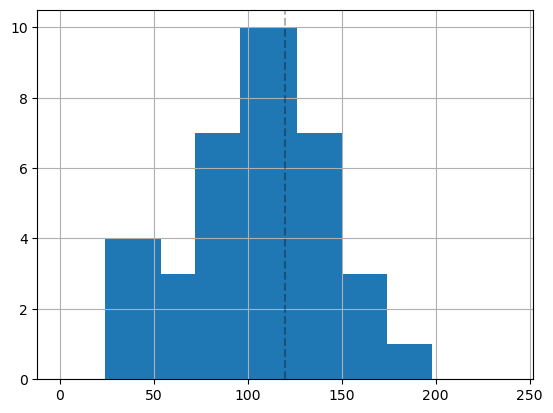

In [69]:
ax = labels.groupby('filename').duration.sum().hist(range=(0, 240), width=30)
ax.axvline(120, color='black', alpha=0.3, ls='--', zorder=10, label='target')

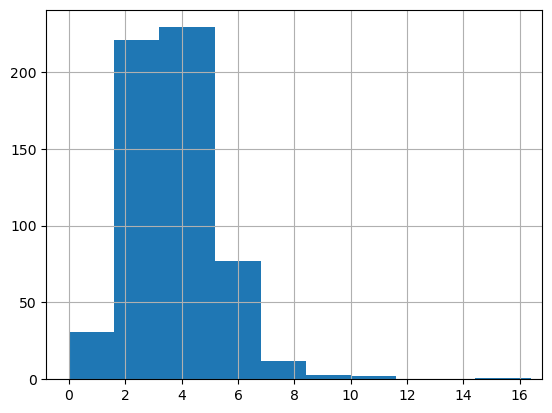

In [83]:
ax = labels.gap.hist(range=(0, 16), width=2)